평균 손실: 0.033414280507713556


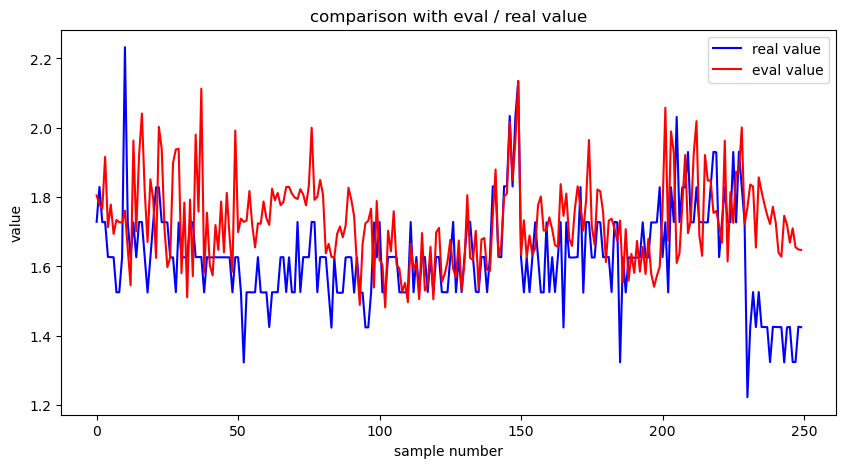

In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from rnn_model import RNNModel
# 수정된 PaddingCollate 클래스
class PaddingCollate:
    @staticmethod
    def __call__(batch):
        time = [item['data'][0] for item in batch]
        pin1 = [item['data'][1] for item in batch]
        pin2 = [item['data'][2] for item in batch]

        max_length_pin1 = max(len(seq) for seq in pin1)
        max_length_pin2 = max(len(seq) for seq in pin2)
        max_length = max(max_length_pin1, max_length_pin2)

        padded_pin1 = []
        padded_pin2 = []

        for seq1, seq2 in zip(pin1, pin2):
            # 리스트를 텐서로 변환하여 패딩 수행
            padded_pin1.append(PaddingCollate.pad_sequence(seq1.clone().detach(), max_length))
            padded_pin2.append(PaddingCollate.pad_sequence(seq2.clone().detach(), max_length))
        time_tensor = torch.tensor(time, dtype=torch.float)
        padded_pin1_tensor = torch.stack(padded_pin1)
        padded_pin2_tensor = torch.stack(padded_pin2)

        return time_tensor, padded_pin1_tensor, padded_pin2_tensor

    @staticmethod
    def pad_sequence(sequence, max_length):
        padding_length = max_length - sequence.size(0)
        padded_sequence = torch.nn.functional.pad(sequence, (0, padding_length))
        return padded_sequence


# 저장된 모델 파일 경로
model_file = 'rnn_model.pth'

# 데이터셋 파일 경로
dataset_file = 'concatenated_dataset.pth'

# 모델 불러오기
model = RNNModel(input_size=2, hidden_size=50, output_size=1, num_layers=2)
model.load_state_dict(torch.load(model_file))
model.eval()  # 평가 모드로 설정

# 데이터셋 로드
dataset = torch.load(dataset_file)

# DataLoader 생성
batch_size = 50
dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=PaddingCollate())

# 손실 함수 정의
criterion = nn.MSELoss()

# 평가 지표 초기화
total_loss = 0
predictions = []
targets = []

# 평가 시작
with torch.no_grad():  # 그라디언트 계산 비활성화
    for time, pin1, pin2 in dataloader:
        inputs = torch.stack([pin1, pin2], dim=2).float()
        target = time.float()

        # 모델 예측
        output = model(inputs)

        # 손실 계산
        loss = criterion(output.squeeze(), target)
        total_loss += loss.item()

        # 예측 값과 실제 값 저장
        predictions.extend(output.squeeze().tolist())
        targets.extend(target.tolist())

# 전체 평균 손실 계산
avg_loss = total_loss / len(dataloader)

# 결과 출력
print(f'평균 손실: {avg_loss}')

# 예측 값과 실제 값 시각화
plt.figure(figsize=(10, 5))
plt.plot(targets, label='real value', color='blue')
plt.plot(predictions, label='eval value', color='red')
plt.xlabel('sample number')
plt.ylabel('value')
plt.title('comparison with eval / real value')
plt.legend()
plt.show()
